In [1]:
from RandomForest_MPI import *
from os import system
from os import path
from os import listdir
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import pickle
import gc
from tqdm import tqdm_notebook

def split_and_save(data, labels, savepath):
    Splitted = train_test_split(data, labels, test_size=0.2, shuffle=True, stratify=labels)
    names = ['X_tr', 'X_v', 'y_tr', 'y_v']
    for vals, name in zip(Splitted, names):
        np.save(path.join(savepath, name), vals)
    return Splitted

#CORRECT SCRIPT NAME
def call_forest(n_jobs, data, labels, n_trees, max_depth, feature_size, out):
    call_str = 'mpirun -np {} python RandomForest_MPI.py -d {} -l {} -nt {} -md {} -fs {} -o {}'
    call_str = call_str.format(n_jobs, data, labels, n_trees, max_depth, feature_size, out)
    print(call_str)
    system(call_str)
    return out, data, labels, n_trees, max_depth

def get_model(out):
    with open(out, 'rb') as fn:
        model = pickle.load(fn)
    return model

def build_curve(labels, preds):
    #fpr, tpr, _ = roc_curve(labels, preds[:, 1])
    #score = roc_auc_score(labels, preds[:, 1])
    fpr, tpr, _ = roc_curve(labels, preds)
    score = roc_auc_score(labels, preds)
    fpr = np.pad(fpr, (1, 1), mode='constant', constant_values=(0,1))
    tpr = np.pad(tpr, (1, 1), mode='constant', constant_values=(0,1))
    fig, ax = plt.subplots(figsize=[9, 9])
    
    ax.plot(np.linspace(0, 1, 20), np.linspace(0, 1, 20), linestyle='--')
    ax.plot(fpr, tpr,label='ROC AUC = {}'.format(round(score, 3)))
    ax.legend(loc=4)
    ax.grid()
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')

def BFS(model):
    queue = [model.root]
    while queue:
        curr = queue.pop(0)
        if not curr.is_leaf:
            print(f'Feature index = {curr.feature}')
            print(f'Best threshold = {curr.threshold}')
            queue.append(curr.left_child)
            queue.append(curr.right_child)

## Cancer data:

In [2]:
df_cancer = pd.read_csv('Data/cancer.csv')
df_cancer['label'], enc_c = pd.factorize(df_cancer['label'])
print(enc_c)
df_cancer.head()

Index(['M', 'B'], dtype='object')


,label,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,0,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,0,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,0,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,0,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
num_data_canc = df_cancer.drop(columns='label').values
labels_canc = df_cancer['label'].values

### Building a single forest:

In [4]:
savepath_c = 'Data/CancerTrainVal'
X_trc, X_vc, y_trc, y_vc = split_and_save(num_data_canc, labels_canc, savepath_c)

In [21]:
n_jobs = 4
data = 'Data/CancerTrainVal/X_tr.npy'
labels = 'Data/CancerTrainVal/y_tr.npy'
n_trees = 20
max_depth = 3
feature_size = 0.15
out = 'Cancer.p'

% time call_forest(n_jobs, data, labels, n_trees, max_depth, feature_size, out)

mpirun -np 4 python RandomForest_MPI.py -d Data/CancerTrainVal/X_tr.npy -l Data/CancerTrainVal/y_tr.npy -nt 20 -md 3 -fs 0.15 -o Cancer.p
CPU times: user 1.02 ms, sys: 8.12 ms, total: 9.14 ms
Wall time: 1 s


('Cancer.p',
 'Data/CancerTrainVal/X_tr.npy',
 'Data/CancerTrainVal/y_tr.npy',
 20,
 3)

In [22]:
model = get_model(out)
preds = model.predict_proba(X_vc)

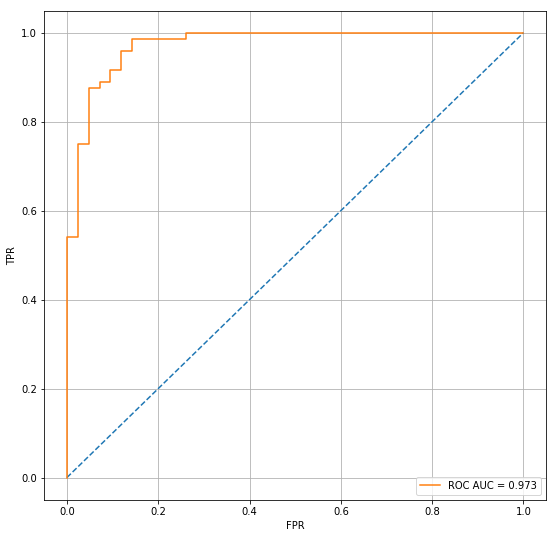

In [23]:
build_curve(y_vc, preds)

### Using CV to find best parameters:

In [72]:
def CV_split_and_save(data, labels, save_path):
    from sklearn.model_selection import StratifiedKFold
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    i = 1
    for train_index, test_index in skf.split(data, labels):
        np.save(path.join(save_path, f'Fold{i}/X_tr'), data[train_index])
        np.save(path.join(save_path, f'Fold{i}/X_v'), data[test_index])
        np.save(path.join(save_path, f'Fold{i}/y_tr'), labels[train_index])
        np.save(path.join(save_path, f'Fold{i}/y_v'), labels[test_index])
        i += 1
    
def get_forests(CVdata_path, njobs, n_trees=100, max_depth=10, feature_size=0.3):
    from os import listdir
    import time
    for folder in tqdm_notebook(listdir(CVdata_path)):
        start = time.clock()
        out = path.join(CVdata_path, folder)
        X_tr = path.join(out, 'X_tr.npy')
        y_tr = path.join(out, 'y_tr.npy')
        out = path.join(out, f'RF_{folder}.p')
        call_forest(n_jobs, X_tr, y_tr, n_trees, max_depth, feature_size, out)

def metrics_on_prunned(CVdata_path, new_ntrees, new_max_depth):
    from itertools import product
    from os import listdir
    folders = listdir(CVdata_path)
    results = []
    models = []
    data = []
    labels = []
    for folder in folders:
        model = get_model(path.join(CVdata_path, folder, f'RF_{folder}.p'))
        model.prunify()
        models.append(model)
        data.append(np.load(path.join(CVdata_path, folder, 'X_v.npy')))
        labels.append(np.load(path.join(CVdata_path, folder, 'y_v.npy')))
    for n_tree, depth in product(new_ntrees, new_max_depth):
        info = {'score': None, 'n_tree': n_tree, 'max_depth': depth}
        temp_roc = []
        for i, model in enumerate(models):
            p = model.predit_proba_prunned(data[i], n_tree, depth)
            score = roc_auc_score(labels[i], p)
            temp_roc.append(score)
        info['score'] = np.mean(temp_roc)
        results.append(info)
    return results

def mean_ROC(CVdata_path, n_trees, max_depth):
    from os import listdir
    from scipy import interp
    folders = listdir(CVdata_path)
    nfolds = len(folders)
    
    scores = []
    fprs = []
    tprs = []
    
    fig, ax = plt.subplots(figsize = [10, 10])
    ax.set_title('Best model ROC curve')
    ax.plot(np.linspace(0, 1, 20), np.linspace(0, 1, 20), linestyle='--')
    ax.grid()
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    
    for folder in folders:
        model = get_model(path.join(CVdata_path, folder, f'RF_{folder}.p'))
        model.prunify()
        y_v = np.load(path.join(CVdata_path, folder, 'y_v.npy'))
        X_v = np.load(path.join(CVdata_path, folder, 'X_v.npy'))
        p = model.predit_proba_prunned(X_v, n_trees, max_depth)
        fpr, tpr, _ = roc_curve(y_v, p)
        fprs.append(fpr)
        tprs.append(tpr)
        score = roc_auc_score(y_v, p)
        scores.append(score)
        ax.plot(fpr, tpr, label=f'Fold {folder[-1]}', linestyle='--', alpha=0.5)
    #INTERPOLATE
    unique_fprs = np.unique(np.concatenate(fprs, axis=0))
    mean_tpr = np.zeros_like(unique_fprs)
    for i in range(nfolds):
        mean_tpr += interp(unique_fprs, fprs[i], tprs[i])
    mean_tpr /= nfolds
    unique_fprs = np.pad(unique_fprs, (1, 1), mode='constant', constant_values=(0,1))
    mean_tpr = np.pad(mean_tpr, (1, 1), mode='constant', constant_values=(0,1))
    ax.plot(unique_fprs, mean_tpr, label=f'Mean ROC\nMean AUC = {round(np.mean(scores), 3)}', color='red')
    ax.legend(loc=4)
        

In [81]:
savepath = 'Data/CancerCV/'

In [36]:
CV_split_and_save(num_data_canc, labels_canc, savepath)

In [37]:
get_forests(savepath, njobs=4)

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))

mpirun -np 4 python RandomForest_MPI.py -d Data/CancerCV/Fold1/X_tr.npy -l Data/CancerCV/Fold1/y_tr.npy -nt 100 -md 10 -fs 0.3 -o Data/CancerCV/Fold1/RF_Fold1.p
mpirun -np 4 python RandomForest_MPI.py -d Data/CancerCV/Fold2/X_tr.npy -l Data/CancerCV/Fold2/y_tr.npy -nt 100 -md 10 -fs 0.3 -o Data/CancerCV/Fold2/RF_Fold2.p
mpirun -np 4 python RandomForest_MPI.py -d Data/CancerCV/Fold3/X_tr.npy -l Data/CancerCV/Fold3/y_tr.npy -nt 100 -md 10 -fs 0.3 -o Data/CancerCV/Fold3/RF_Fold3.p
mpirun -np 4 python RandomForest_MPI.py -d Data/CancerCV/Fold4/X_tr.npy -l Data/CancerCV/Fold4/y_tr.npy -nt 100 -md 10 -fs 0.3 -o Data/CancerCV/Fold4/RF_Fold4.p
mpirun -np 4 python RandomForest_MPI.py -d Data/CancerCV/Fold5/X_tr.npy -l Data/CancerCV/Fold5/y_tr.npy -nt 100 -md 10 -fs 0.3 -o Data/CancerCV/Fold5/RF_Fold5.p



In [82]:
result = metrics_on_prunned(savepath, new_ntrees=[5, 10, 20, 30, 50, 100], new_max_depth=[2, 3, 5, 7, 10])

In [83]:
print('Best parameters are: ')
print(sorted(result, key=lambda x: x['score'], reverse = True)[0])

Best parameters are: 
{'score': 0.99146909883071044, 'n_tree': 50, 'max_depth': 7}


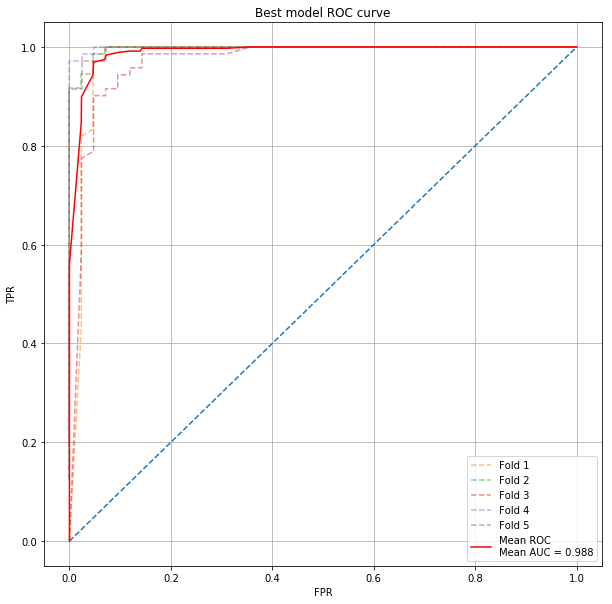

In [84]:
mean_ROC(savepath, 50, 7)

## Spam data:

In [74]:
df_spam = pd.read_csv('Data/spam.csv')
df_spam.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_:,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,label
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [75]:
num_data_spam = df_spam.drop(columns='label').values
labels_spam = df_spam['label'].values

savepath_s = 'Data/SpamTrainVal'
X_trs, X_vs, y_trs, y_vs = split_and_save(df_spam.drop(columns='label'), df_spam['label'], savepath_s)

In [55]:
n_jobs = 4
data = 'Data/SpamTrainVal/X_tr.npy'
labels = 'Data/SpamTrainVal/y_tr.npy'
n_trees = 20
max_depth = 3
feature_size = 0.15
out = 'Spam.p'

% time call_forest(n_jobs, data, labels, n_trees, max_depth, feature_size, out)

mpirun -np 4 python RandomForest_MPI.py -d Data/SpamTrainVal/X_tr.npy -l Data/SpamTrainVal/y_tr.npy -nt 20 -md 3 -fs 0.15 -o Spam.p
CPU times: user 3.31 ms, sys: 8.39 ms, total: 11.7 ms
Wall time: 3.34 s


('Spam.p', 'Data/SpamTrainVal/X_tr.npy', 'Data/SpamTrainVal/y_tr.npy', 20, 3)

In [56]:
model = get_model(out)
preds = model.predict_proba(X_vs)

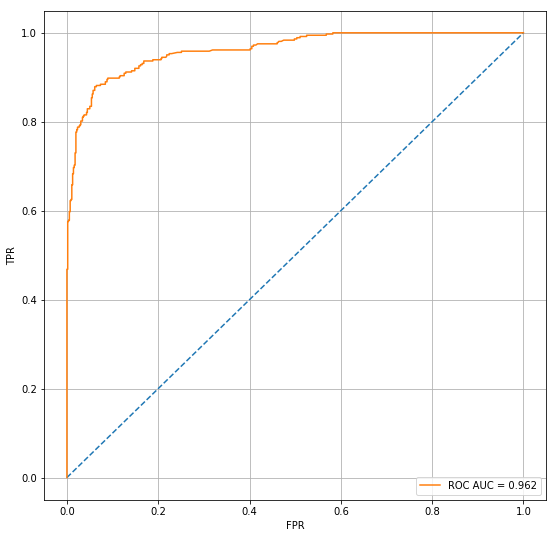

In [57]:
build_curve(y_vs, preds)

### Using CV to find best parameters

In [85]:
savepath = 'Data/SpamCV/'

In [76]:
CV_split_and_save(num_data_spam, labels_spam, savepath)

In [78]:
get_forests(savepath, njobs=4)

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))

mpirun -np 4 python RandomForest_MPI.py -d Data/SpamCV/Fold1/X_tr.npy -l Data/SpamCV/Fold1/y_tr.npy -nt 100 -md 10 -fs 0.3 -o Data/SpamCV/Fold1/RF_Fold1.p
mpirun -np 4 python RandomForest_MPI.py -d Data/SpamCV/Fold2/X_tr.npy -l Data/SpamCV/Fold2/y_tr.npy -nt 100 -md 10 -fs 0.3 -o Data/SpamCV/Fold2/RF_Fold2.p
mpirun -np 4 python RandomForest_MPI.py -d Data/SpamCV/Fold3/X_tr.npy -l Data/SpamCV/Fold3/y_tr.npy -nt 100 -md 10 -fs 0.3 -o Data/SpamCV/Fold3/RF_Fold3.p
mpirun -np 4 python RandomForest_MPI.py -d Data/SpamCV/Fold4/X_tr.npy -l Data/SpamCV/Fold4/y_tr.npy -nt 100 -md 10 -fs 0.3 -o Data/SpamCV/Fold4/RF_Fold4.p
mpirun -np 4 python RandomForest_MPI.py -d Data/SpamCV/Fold5/X_tr.npy -l Data/SpamCV/Fold5/y_tr.npy -nt 100 -md 10 -fs 0.3 -o Data/SpamCV/Fold5/RF_Fold5.p



In [87]:
result = metrics_on_prunned(savepath, new_ntrees=[5, 10, 20, 30, 50, 100], new_max_depth=[2, 3, 5, 7, 10])

In [88]:
print('Best parameters are: ')
print(sorted(result, key=lambda x: x['score'], reverse = True)[0])

Best parameters are: 
{'score': 0.98354772117465961, 'n_tree': 100, 'max_depth': 10}


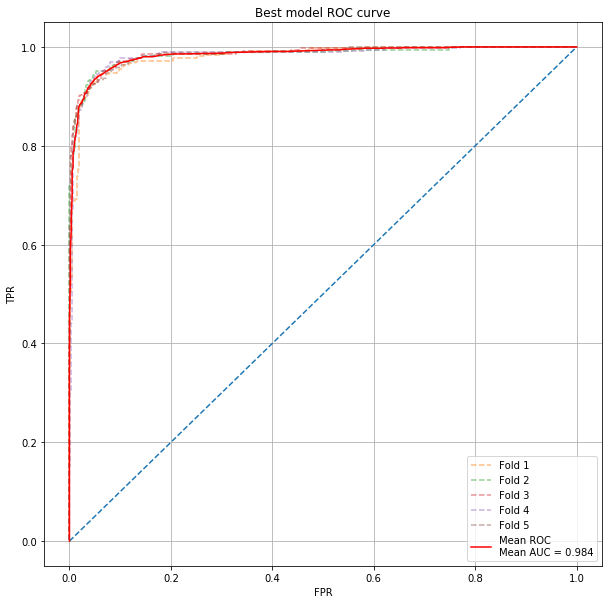

In [89]:
mean_ROC(savepath, 100, 10)